# PHYS 210 Mini-Project 02
### RLC Oscillations
Due Mon, Nov 14, 2022 - 9am

#### Project objective

Use `solve_ivp()` to solve the differential equation governing a series RLC circuit, looking at the behaviours of underdamped, critically damped, and overdamped circuits.

#### Before getting started

1. Read the Mini-Project 02 background handout in the same folder as this notebook
1. Read the updated grading rubric document, also in this folder (and on Canvas). It was updated so that the total sums to 100 points, not including the bonus categories.

#### Part 1. Initial Set-up

So that your solutions are as general as possible, we are going to generate random values for your inductance and capacitance in the circuit, with some constraints. Your solutions from one execution of your code to the next might be multiple orders of magnitude different, so decisions about which ranges of values to include should be automated to some extent so that the graphs are able to always show the desired features clearly.

Choose random values of $L$ and $C$, with the following constraints:

1. Start by generating a two-digit integer, $a_L$ between 10 and 99 (inclusive), and
1. A random integer, $b_L$, between -5 and -9 (inclusive) for the exponent.

The inductance is then given by $L = {a_L} \times 10^{b_L}$ Henries.

Repeat this process using the same constraints, but with _**new**_ random numbers to get the capacitance, $C = {a_C} \times 10^{b_C}$ Farad.

Finally, we determine three values of $R$, to represent the underdamped, critically damped and overdamped cases, respectively, based on the already determined values of $L$ and $C$:

$$R_1 = \frac{1}{10} \times 2\pi\sqrt{\frac{L}{C}}$$
$$R_2 = 2\pi\sqrt{\frac{L}{C}}$$
$$R_3 = 5 \times 2\pi\sqrt{\frac{L}{C}}$$

In [1]:
# generate L, C and R values here
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
"""
This program(excluding the extension) functions with 3 parts. Part one is a
calculation of a random capacitance and inductance, and uses these values to
generate 3 resistances, an under damped resistance, critically damped
resistance, and an overdamped resistance. These values are initially used in
part two to calculate and plot current response in the time domain, then in
part 3 as constants in a plot of RMS steady state current in the frequency
domain

The initial constant declarations are below, with cells used to
split code into the following categories:

1) imports and declarations
2) function definitions
2) solution calculation
3) plotting results

This was done to increase modularity, so all code does not need to be
constantly rerun when changing individual sections.

In order to use this code for other LRC circuit simulations, the solution
function can be changed for other driving voltage functions(such as in the
extension)

Optimizations and features not taught in class include the usage of the map()
function when evaluating the frequency domain response. This function was used
because it greatly reduces computation time(it was written in C), so every
value does not need to be iterated upon in python.
"""

# Generating random values
al = np.random.randint(10, 100)
bl = -np.random.randint(5, 10)

ac = np.random.randint(10, 100)
bc = -np.random.randint(5, 10)

L = al * 10**bl  # Henry
C = ac * 10**bc  # Farad

# Calculating under, critical, and over damped resistances
R1 = 0.1 * np.sqrt(L / C)  # Ohms
R2 = np.sqrt(L / C)  # Ohms
R3 = 5 * np.sqrt(L / C)  # Ohms

# String Building
circuitparamsnoR = "L={0}*10^{1} Henry\nC={2}*10^{3} Farad\n".format(
    al, bl, ac, bc)
circuitparamsR1 = circuitparamsnoR + "R={0:.5} Ohms\n".format(R1)
circuitparamsR2 = circuitparamsnoR + "R={0:.5} Ohms\n".format(R2)
circuitparamsR3 = circuitparamsnoR + "R={0:.5} Ohms\n".format(R3)

# Circuit Value reporting
print("circuit 1 (Underdamped):\n", circuitparamsR1)
print("circuit 2 (Critically Damped):\n", circuitparamsR2)
print("circuit 3 (Over-Damped):\n", circuitparamsR3)

circuit 1 (Underdamped):
 L=30*10^-6 Henry
C=94*10^-5 Farad
R=0.017865 Ohms

circuit 2 (Critically Damped):
 L=30*10^-6 Henry
C=94*10^-5 Farad
R=0.17865 Ohms

circuit 3 (Over-Damped):
 L=30*10^-6 Henry
C=94*10^-5 Farad
R=0.89324 Ohms



#### Part 2: Time evolution of the current in the three circuits

We will use a primary observable of the current in the circuit $I(t)=dq(t)/dt$ to describe what is happening in each circuit. The current in the circuit is driven by an AC voltage source, with amplitude $V_0$ and frequency $\omega$, much like how you can increase the amplitude of a person on a swing by providing an external periodic push. We will have our voltage source provide its voltage at a frequency of $\omega = \omega_0 = 1/\sqrt{LC}$ to match the resonant frequency of the circuit, much like how you want to match the timing of your pushes to the oscillation frequency of the person on the swing.

These types of systems can take a while to settle into their steady-state oscillatory behaviour, so we want to see how long it takes each circuit to get to get to a steady-state amplitude for the current, starting from an initial state of no charge on the capacitor, $q(0)=0$ and no current in the circuit, $I(0)=0$.

**The task:** 

* Generate a 3-panel figure that shows the time evolution of $I(t)$ for the three cases above, driven by a sinusoidal voltage of $(V_0 = 0.1\textrm{V})$ at a frequency of $\omega = \omega_0$. Start with the initial conditions of no charge stored in the capacitor and no current in the circuit, $q(0) = I(0) = 0$.
* Ensure that your code chooses the time interval and time steps wisely so that it captures the behaviour of the oscillator, such that you can see the evolution (known as the transient) from  $I(0) = 0$ to the stable amplitude of the oscillating current. One challenge is to write the program so that it will work well over the large range of possible $L$ and $C$ values generated from the random numbers, will work well across the three types of damping, and will still generate plots showing the requested features. You should test your code with the Validate button several times, which should generate new random values of $L$ and $C$ to ensure that your plots look good each time.

**The small details:**

* The figure should consist of _three_ vertically stacked subplots, each showing the behaviour for one of the damping cases, clearly labelled as underdamped, critically damped and overdamped.
* The values of the randomly generated R, L and C should be indicated in the titles of each panel.
* You should use a common time interval across all three subplots.

In [2]:
# Part 2 Constant Definitions
w0 = 1 / np.sqrt(L * C)  # Rads/s

v0 = 0.1  # V

partonewavelengths = 25

# initial conditions: [q,q']
q0_arr = [0, 0]

In [3]:
# 2nd Order ODE solution function
def solution(r, w, wavelengths):
    """
    This function solves the 2nd order differential equation for the LRC
    circuit. It does so using resistance, input frequency, and the amount of
    wavelengths to generate. It then uses these values to generate an array.
    It outputs the solutions to the differential equation with t_sol_out
    representing the time steps generated and y_sol_out are each of the
    values at that point in time, ordered in an array as [q, dq].

    No value for t_eval was given to the integration solver, because the
    integrate function is able to generate points itself, which adapts
    automatically to the ODE system given.

    :param r: Circuit resistance in ohms (float)
    :param w: Circuit driving voltage sin wave ang. frequency rads/s(float)
    :param wavelengths: Number of wavelengths to simulate (float or int)
    :return: tuple of (time solution array, [q, dq] array) (np.array)
    """

    # Time variables
    t0 = 0.0
    tmax = wavelengths * (2 * np.pi) / w

    def dqdt_arr(t, q):
        """
        This function defines the derivatives of q and dq as a function of
        current q = [q, dq] and t. The input is a sin wave AC voltage.
        Resistance of the circuit and frequency of the input sin wave are
        defined as inputs to the outer function.
        This function is nested because resistance and angular frequency
        change depending on the circuit being simulated
        :param t: Time, where t+1=t+dt (float)
        :param q: Current array of [q, dq] (np.array)
        :return: Next array of [q, dq] (np.array)
        """
        next_q = q[1]
        next_dq = (v0 * np.sin(w * t) / L) - (r / L) * q[1] - q[0] / (L * C)
        return [next_q, next_dq]

    # Solving the differential equation
    sol = integrate.solve_ivp(dqdt_arr, (t0, tmax), q0_arr, method='LSODA')

    t_sol_out = sol['t']  # getting time values
    y_sol_out = sol['y']  # getting y0_arr values for each time step

    return t_sol_out, y_sol_out

In [4]:
# Part 2 Solution Cell
t_sol1, y_sol1 = solution(R1, w0, partonewavelengths)
t_sol2, y_sol2 = solution(R2, w0, partonewavelengths)
t_sol3, y_sol3 = solution(R3, w0, partonewavelengths)

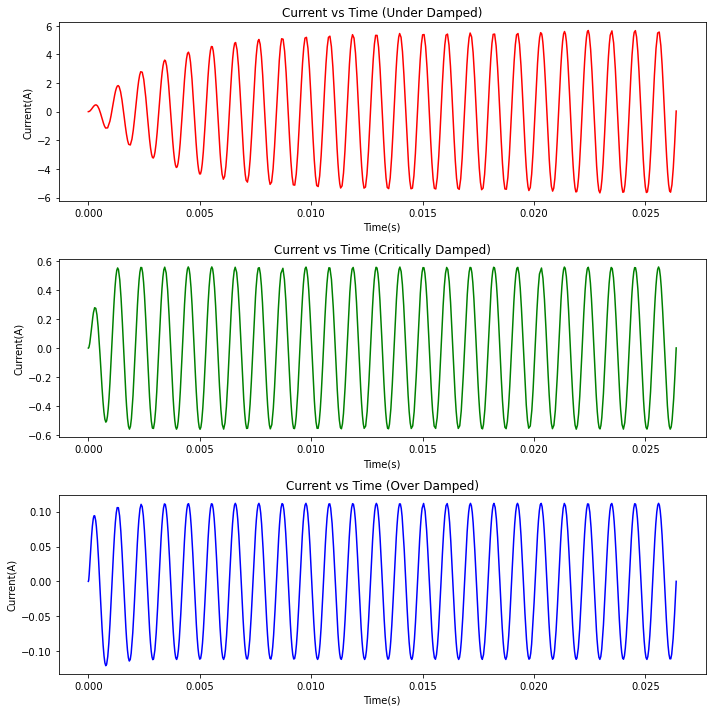

In [5]:
# Part 2 Plotting cell
plt.figure(figsize=(10, 10))


plt.subplot(3, 1, 1)
plt.plot(t_sol1, y_sol1[1], "r-", label="Current")
plt.title("Current vs Time (Under Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")


plt.subplot(3, 1, 2)
plt.plot(t_sol2, y_sol2[1], "g-", label="Current")
plt.title("Current vs Time (Critically Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")

plt.subplot(3, 1, 3)
plt.plot(t_sol3, y_sol3[1], "b-", label="Current")
plt.title("Current vs Time (Over Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")

plt.tight_layout()
plt.show()

#### Part 3: Resonance plots

Lastly, we want to explore how the steady-state amplitude in each of the three circuits depends on the frequency $(\omega)$ of the sinusoidal driving voltage. Resonance, which occurs when the provided driving frequency closely matches the natural/resonant frequency of the system, is famously the cause of the Tacoma Narrows bridge collapse.

To explore the dependence of the steady-state amplitude of the current on the frequency $(\omega)$ of the sinusoidal driving voltage, generate another figure with three vertically-stacked subplots. Each panel/subplot should show a plot of the steady-state amplitude of the current vs the frequency of the driving voltage for a range from 

$$0.1 \frac{\omega_0}{2 \pi} \; \textrm{ to }\; 2 \frac{\omega_0}{2 \pi}.$$.

The three panels should show the resonance curves (amplitude of the steady-state current vs $\omega$), clearly labelled for the three damping cases. For each point you plot, the current should represent the amplitude of the response current (for a drive amplitude of $V_0 = 0.1\textrm{V}$) at a time _after_ the transient behaviour has died away, such that and the current has stabilized to a steady sinusoidal oscillation. Your calculations should be made at frequencies spaced closely enough that when plotted with a continuous line, the curves are smooth. The values of R, L and C should be indicated in the titles of each panel. The plots should use Hz units ($\omega/2\pi$).

This will require calling `solve_ivp()` numerous times and will require more cpu time to execute than anything we have seen so far, though should in total not take more than a minute or so.

**The small details:**

* The figure should consist of _three_ vertically stacked subplots, each showing the behaviour for one of the damping cases, clearly labelled as underdamped, critically damped and overdamped.
* The values of R, L and C should be indicated in the titles of each panel.

In [6]:
# Part 3 variable initialization
V0 = .1  # V
part_two_wavelengths = 50

In [7]:
# Part 3 Function Definitions
def get_steady_current(currents):
    """
    Returns steady state current of a set of input currents. The function
    assumes the current has reached steady state by the halfway point, then
    returns the steady state

    :param currents: array of currents (np.array)
    :return: RMS voltage of steady state wave V (float)
    """

    after_transient = currents[len(currents) // 2:]
    return (max(after_transient) - min(after_transient)) / (2 * np.sqrt(2))


def solve_and_find_steady(w):
    """
    Composition function of solution(r,w,wavelengths) and get_steady_current
    (currents). The function assumes the global variable R has been
    initialized to a resistance, and uses the input parameter w as the
    angular frequency. This function was designed to work well with the map
    function, so has one input (w) that is iterated upon through a list

    :param w: input angular frequency rads/s (float)
    :return: Steady state current A (float)
    """

    t_sol, y_sol = solution(R, w, part_two_wavelengths)
    return get_steady_current(y_sol[1])

In [8]:
# Part 3 Solution Calculation
num_frequencies = 100

frequencies = np.linspace(0.1 * w0, 2 * w0, num_frequencies)
frequencies_in_hz = frequencies / (2 * np.pi)

# ODE solving to find steady state current
R = R1
currents1 = list(map(solve_and_find_steady, frequencies))

R = R2
currents2 = list(map(solve_and_find_steady, frequencies))

R = R3
currents3 = list(map(solve_and_find_steady, frequencies))

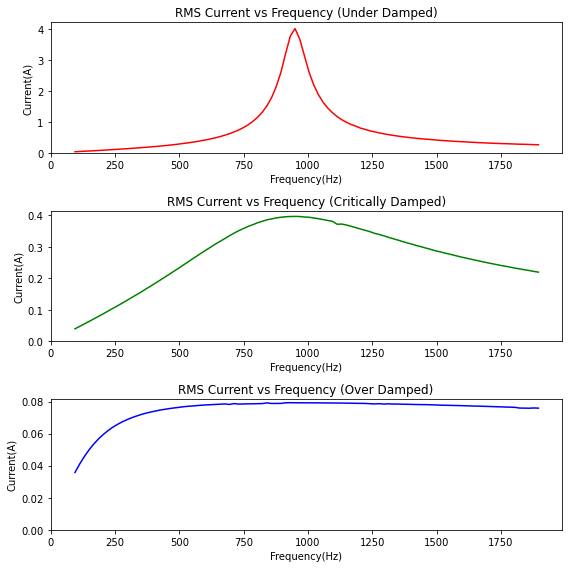

In [9]:
# Part 3 Plotting Cell
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
plt.plot(frequencies_in_hz, currents1, "r-", label="Current")
plt.title("RMS Current vs Frequency (Under Damped)")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Current(A)")
plt.ylim(ymin=0)
plt.xlim(xmin=0)

plt.subplot(3, 1, 2)
plt.plot(frequencies_in_hz, currents2, "g-", label="Current")
plt.title("RMS Current vs Frequency (Critically Damped)")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Current(A)")
plt.ylim(ymin=0)
plt.xlim(xmin=0)

plt.subplot(3, 1, 3)
plt.plot(frequencies_in_hz, currents3, "b-", label="Current")
plt.title("RMS Current vs Frequency (Over Damped)")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Current(A)")

plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.tight_layout()
plt.show()

In [10]:
# B1. OPTIONAL project extension here
# These can call functions in your code above if desired
# YOUR CODE HERE
from scipy import signal

extension_wavelengths = 10


def arbitrary_voltage_solution(r, w, wavelengths, driving_function=np.sin, v0=0.1):
    """
    This function solves the 2nd order differential equation for the LRC
    circuit. It does so using resistance, input frequency, and the amount of
    wavelengths to generate. It then uses these values to generate an array  It
    outputs the solutions to the differential equation with t_sol_out
    representing the time steps generated and y_sol_out are each of the
    values at that point in time, ordered in an array as [q, dq]. If no driving
    function is given, then it is assumed to be np.sin, if no v0 is given, then
    it is assumed to be 0.1 V

    :param r: Circuit resistance in ohms (float)
    :param w: Circuit driving voltage sin wave angular frequency rads/s (float)
    :param wavelengths: Number of wavelengths to simulate (float or int)
    :param driving_function: Voltage driving function (function)
    :return: Tuple of (time solution array, [q, dq] array, driving voltage array)
    """

    # Time variables
    t0 = 0.0
    tmax = wavelengths * (2 * np.pi) / w

    def dqdt_arr(t, q):
        """
        This function defines the derivatives of q and dq as a function of
        current q = [q, dq] and t. The input AC voltage is driving_function.
        Resistance of the circuit and frequency of the input sin wave are
        defined as inputs to the outer function.
        This function is nested because resistance and angular frequency
        change depending on the circuit being simulated.
        The function relies upon v0 being globally initialized to the peak
        driving voltage(assuming driving voltage is periodic and has a max
        and min of 1)

        :param t: Time, where t+1=t+dt (float)
        :param q: Current array of [q, dq] (np.array)
        :return: Next array of [q, dq] (np.array)
        """
        next_q = q[1]
        next_dq = (v0 * driving_function(w * t) /
                   L) - (r / L) * q[1] - q[0] / (L * C)
        return [next_q, next_dq]

    # Solving the differential equation
    sol = integrate.solve_ivp(dqdt_arr, (t0, tmax), q0_arr, method='LSODA')

    t_sol_out = sol['t']  # getting time values
    y_sol_out = sol['y']  # getting y0_arr values for each time step
    driving_voltage_out = v0 * driving_function(w * t_sol_out)

    return t_sol_out, y_sol_out, driving_voltage_out

In [11]:
# Extension solution cell for DC on/off cycle(offset square/osquare)
def offsetsquare(t):
    """
    Defines a dc input wave that turns on and off periodically using the
    signal.square function. Accepts time input t, and returns the
    voltage at that time
    """
    return (signal.square(t) + 1) / 2

smallfrequency = w0/10

t_sol1osquare, y_sol1osquare, driving_v1 = arbitrary_voltage_solution(
    R1, smallfrequency, extension_wavelengths, offsetsquare)
t_sol2osquare, y_sol2osquare, driving_v2 = arbitrary_voltage_solution(
    R2, smallfrequency, extension_wavelengths, offsetsquare)
t_sol3osquare, y_sol3osquare, driving_v3 = arbitrary_voltage_solution(
    R3, smallfrequency, extension_wavelengths, offsetsquare)

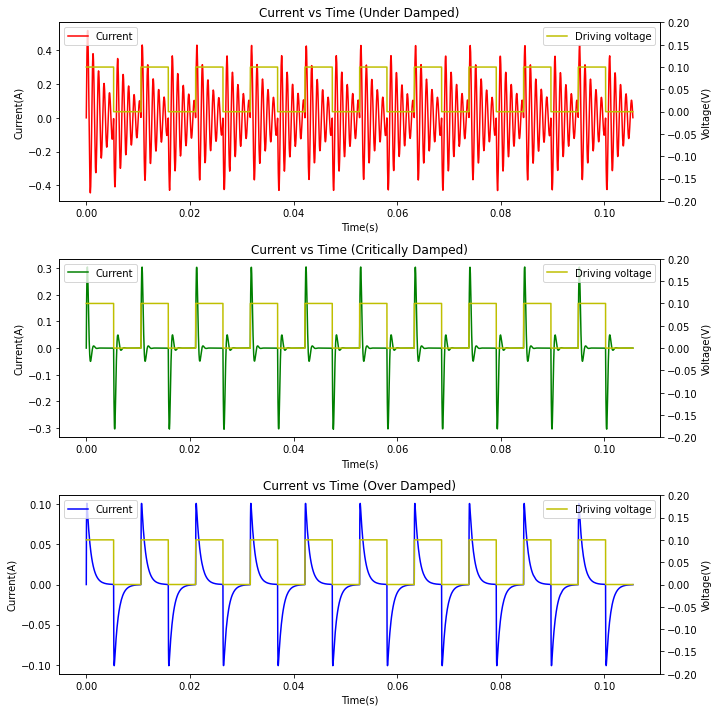

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(t_sol1osquare, y_sol1osquare[1], "r-", label="Current")
plt.title("Current vs Time (Under Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol1osquare, driving_v1, "y-", label="Driving voltage")
plt.ylim(-2 * v0, 2 * v0)
plt.legend(loc="upper right")

plt.subplot(3, 1, 2)
plt.plot(t_sol2osquare, y_sol2osquare[1], "g-", label="Current")
plt.title("Current vs Time (Critically Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol2osquare, driving_v2, "y-", label="Driving voltage")
plt.ylim(-2 * v0, 2 * v0)
plt.legend(loc="upper right")

plt.subplot(3, 1, 3)
plt.plot(t_sol3osquare, y_sol3osquare[1], "b-", label="Current")
plt.title("Current vs Time (Over Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol3osquare, driving_v3, "y-", label="Driving voltage")
plt.ylim(-2 * v0, 2 * v0)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [13]:
# Extension Solution Cell for square wave
t_sol1square, y_sol1square, driving_v1 = arbitrary_voltage_solution(
    R1, w0, extension_wavelengths, signal.square)
t_sol2square, y_sol2square, driving_v2 = arbitrary_voltage_solution(
    R2, w0, extension_wavelengths, signal.square)
t_sol3square, y_sol3square, driving_v3 = arbitrary_voltage_solution(
    R3, w0, extension_wavelengths, signal.square)

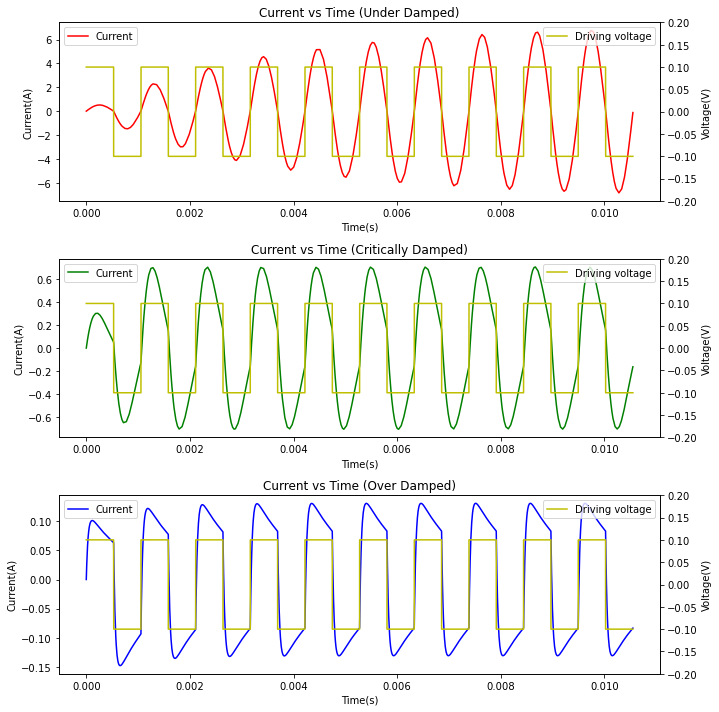

In [14]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(t_sol1square, y_sol1square[1], "r-", label="Current")
plt.title("Current vs Time (Under Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol1square, driving_v1, "y-", label="Driving voltage")
plt.ylim(-2 * v0, 2 * v0)
plt.legend(loc="upper right")

plt.subplot(3, 1, 2)
plt.plot(t_sol2square, y_sol2square[1], "g-", label="Current")
plt.title("Current vs Time (Critically Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol2square, driving_v2, "y-", label="Driving voltage")
plt.ylim(-2 * v0, 2 * v0)
plt.legend(loc="upper right")

plt.subplot(3, 1, 3)
plt.plot(t_sol3square, y_sol3square[1], "b-", label="Current")
plt.title("Current vs Time (Over Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol3square, driving_v3, "y-", label="Driving voltage")
plt.ylim(-2 * v0, 2 * v0)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [15]:
# Extension Solution Cell for sawtooth wave
t_sol1sawtooth, y_sol1sawtooth, driving_v1 = arbitrary_voltage_solution(
    R1, w0, extension_wavelengths, signal.sawtooth)
t_sol2sawtooth, y_sol2sawtooth, driving_v2 = arbitrary_voltage_solution(
    R2, w0, extension_wavelengths, signal.sawtooth)
t_sol3sawtooth, y_sol3sawtooth, driving_v3 = arbitrary_voltage_solution(
    R3, w0, extension_wavelengths, signal.sawtooth)

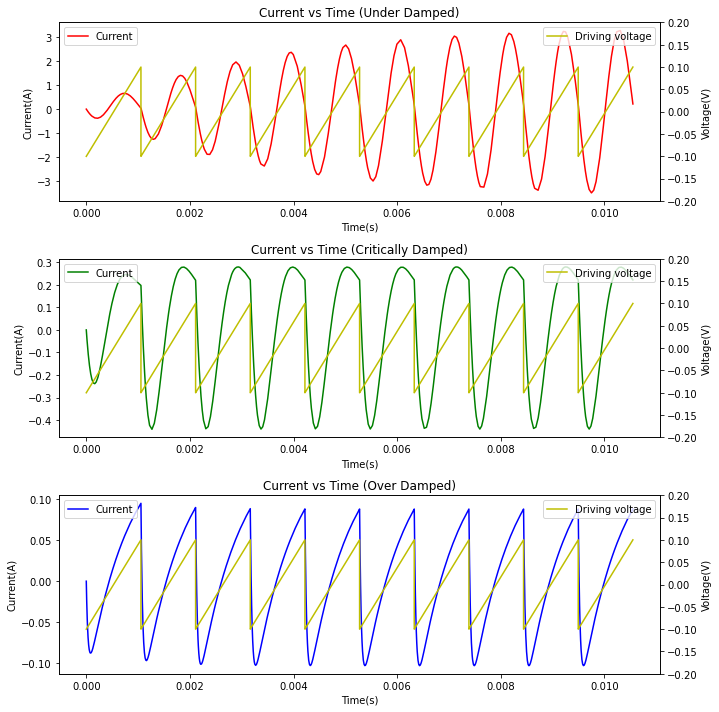

In [16]:
plt.figure(figsize=(10, 10))

# Plot 1
plt.subplot(3, 1, 1)

# Current Plot
plt.plot(t_sol1sawtooth, y_sol1sawtooth[1], "r-", label="Current")
plt.title("Current vs Time (Under Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

# Voltage Plot
plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol1sawtooth, driving_v1, "y-", label="Driving voltage")
plt.ylim(-2*v0,2*v0)
plt.legend(loc="upper right")

# Plot 2
plt.subplot(3, 1, 2)

# Current Plot
plt.plot(t_sol2sawtooth, y_sol2sawtooth[1], "g-", label="Current")
plt.title("Current vs Time (Critically Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

# Voltage Plot
plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol2sawtooth, driving_v2, "y-", label="Driving voltage")
plt.ylim(-2*v0,2*v0)
plt.legend(loc="upper right")

# Plot 3
plt.subplot(3, 1, 3)

# Current Plot
plt.plot(t_sol3sawtooth, y_sol3sawtooth[1], "b-", label="Current")
plt.title("Current vs Time (Over Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

# Voltage Plot
plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol3sawtooth, driving_v3, "y-", label="Driving voltage")
plt.ylim(-2*v0,2*v0)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [17]:
# Extension Solution Cell for triangle wave
def trianglewave(t):
    """
    Defines a triangle wave using the signal.sawtooth function and the
    width parameter. Accepts time input t, and returns the triangle wave
    voltage at that time
    """
    return signal.sawtooth(t, width=0.5)


signal.sawtooth.width = 0.5
t_sol1sawtooth, y_sol1sawtooth, driving_v1 = arbitrary_voltage_solution(
    R1, w0, extension_wavelengths, trianglewave)
t_sol2sawtooth, y_sol2sawtooth, driving_v2 = arbitrary_voltage_solution(
    R2, w0, extension_wavelengths, trianglewave)
t_sol3sawtooth, y_sol3sawtooth, driving_v3 = arbitrary_voltage_solution(
    R3, w0, extension_wavelengths, trianglewave)

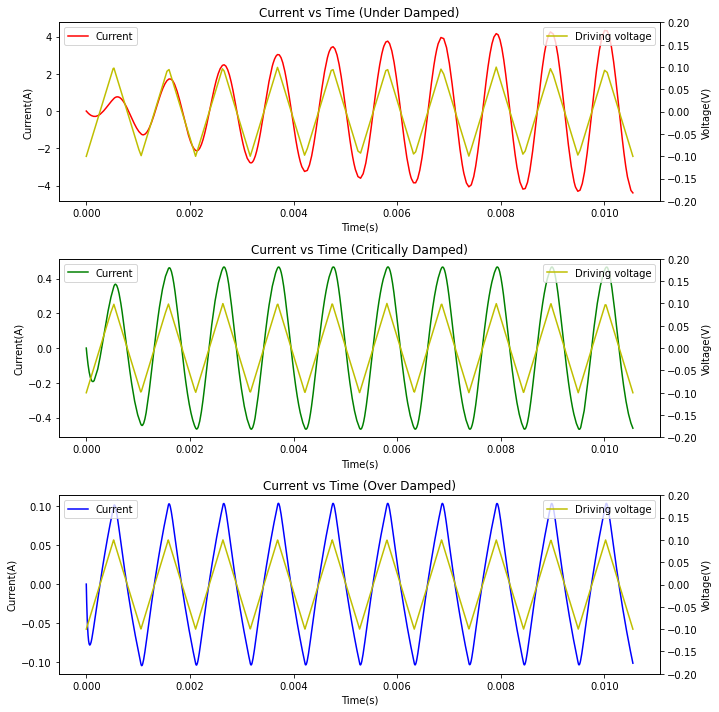

In [18]:
plt.figure(figsize=(10, 10))

# Plot 1
plt.subplot(3, 1, 1)

# Current Plot
plt.plot(t_sol1sawtooth, y_sol1sawtooth[1], "r-", label="Current")
plt.title("Current vs Time (Under Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol1sawtooth, driving_v1, "y-", label="Driving voltage")
plt.ylim(-2*v0,2*v0)
plt.legend(loc="upper right")

# Plot 2
plt.subplot(3, 1, 2)

# Current Plot
plt.plot(t_sol2sawtooth, y_sol2sawtooth[1], "g-", label="Current")
plt.title("Current vs Time (Critically Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol2sawtooth, driving_v2, "y-", label="Driving voltage")
plt.ylim(-2*v0,2*v0)
plt.legend(loc="upper right")

# Plot 3
plt.subplot(3, 1, 3)

# Current Plot
plt.plot(t_sol3sawtooth, y_sol3sawtooth[1], "b-", label="Current")
plt.title("Current vs Time (Over Damped)")
plt.xlabel("Time(s)")
plt.ylabel("Current(A)")
plt.legend(loc="upper left")

# Voltage Plot
plt.twinx()
plt.ylabel("Voltage(V)")
plt.plot(t_sol3sawtooth, driving_v3, "y-", label="Driving voltage")
plt.ylim(-2*v0,2*v0)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

_In this cell, please describe any new language features or project extension you have implemented:_

_Project Extension:_

_The solution function was redefined to accept and arbitrary periodic function input, and output the driving voltages in addition to the time array and solution array. This allows for any periodic function to be tested as a driving voltage._ The transient responses of a DC input that turns on and off, square wave, sawtooth, and triangle wave were plotted, in addition to the driving voltages. The extension functionally acts like a voltage probe and ammeter.

\(Here's a little of my analysis for fun\)

For the purposes of analysis, only the "true oscillating" functions\(everything except DC on/off\) are being analyzed.

The underdamped circuits respond with a sinusoidal wave.

The critically damped responses varied the most, acting as an intermediate between a sinusoidal response, and the shape of the input wave

The over\-damped responses generally approximated the input voltage wave, with slight deviation.

_New Language Features:_

_Part 3/Extension:_ 

_frequency domain calculations are very sped up with the usage of the map\(\) function. This function iterates upon the linear frequency space generated._

_Extension:_

_Two y axis plots are shown with the plt.twinx\(\) function, this allows both the driving voltage to be shown, and the current within the circuit with proper units and clear scales._



# Grading cells
The cells below marked as "grade use only" are created as placeholders so that we can provide a manual grade and comments for each category. 

Exceptions are the "2. Style" test, which has an associated autograder test that you can run to check style and the timing cell "cell-optimization0", which you can use to test your code execution time.

In [19]:
# 1. Code execution (grader use only)

In [20]:
# 2. Style: pep8 (see note below regarding use of the Format button to fix many errors)
#
# Tests for pep8 returns warnings or errors. You may need to hit 'Save' after making changes for them to take effect.
nb_name = "project02.ipynb"
cells_to_check = []
stop_at = ['cell-extension']
# check_style2.py uses cells_to_check and nb_name
%run -i check_style2.py

Exception: File `'check_style2.py'` not found.

Also note that you can use the Format button while in a code cell to automagically fix most pep8 errors (other than way too long print statements)

![](project02-format.png)

In [ ]:
# 3. Results (grader use only)

In [ ]:
# 4. Readability (grader use only)

In [ ]:
# 5. Plot (grader use only)

circuit 1 (Underdamped):
 L=34*10^-8 Henry
C=11*10^-8 Farad
R=0.17581 Ohms

circuit 2 (Critically Damped):
 L=34*10^-8 Henry
C=11*10^-8 Farad
R=1.7581 Ohms

circuit 3 (Over-Damped):
 L=34*10^-8 Henry
C=11*10^-8 Farad
R=8.7905 Ohms

Time for cell: cell-project2-1 time: 0.00
Time for cell: cell-project2-2 time: 0.00
Time for unnamed cell: 0.00
Time for unnamed cell: 0.05


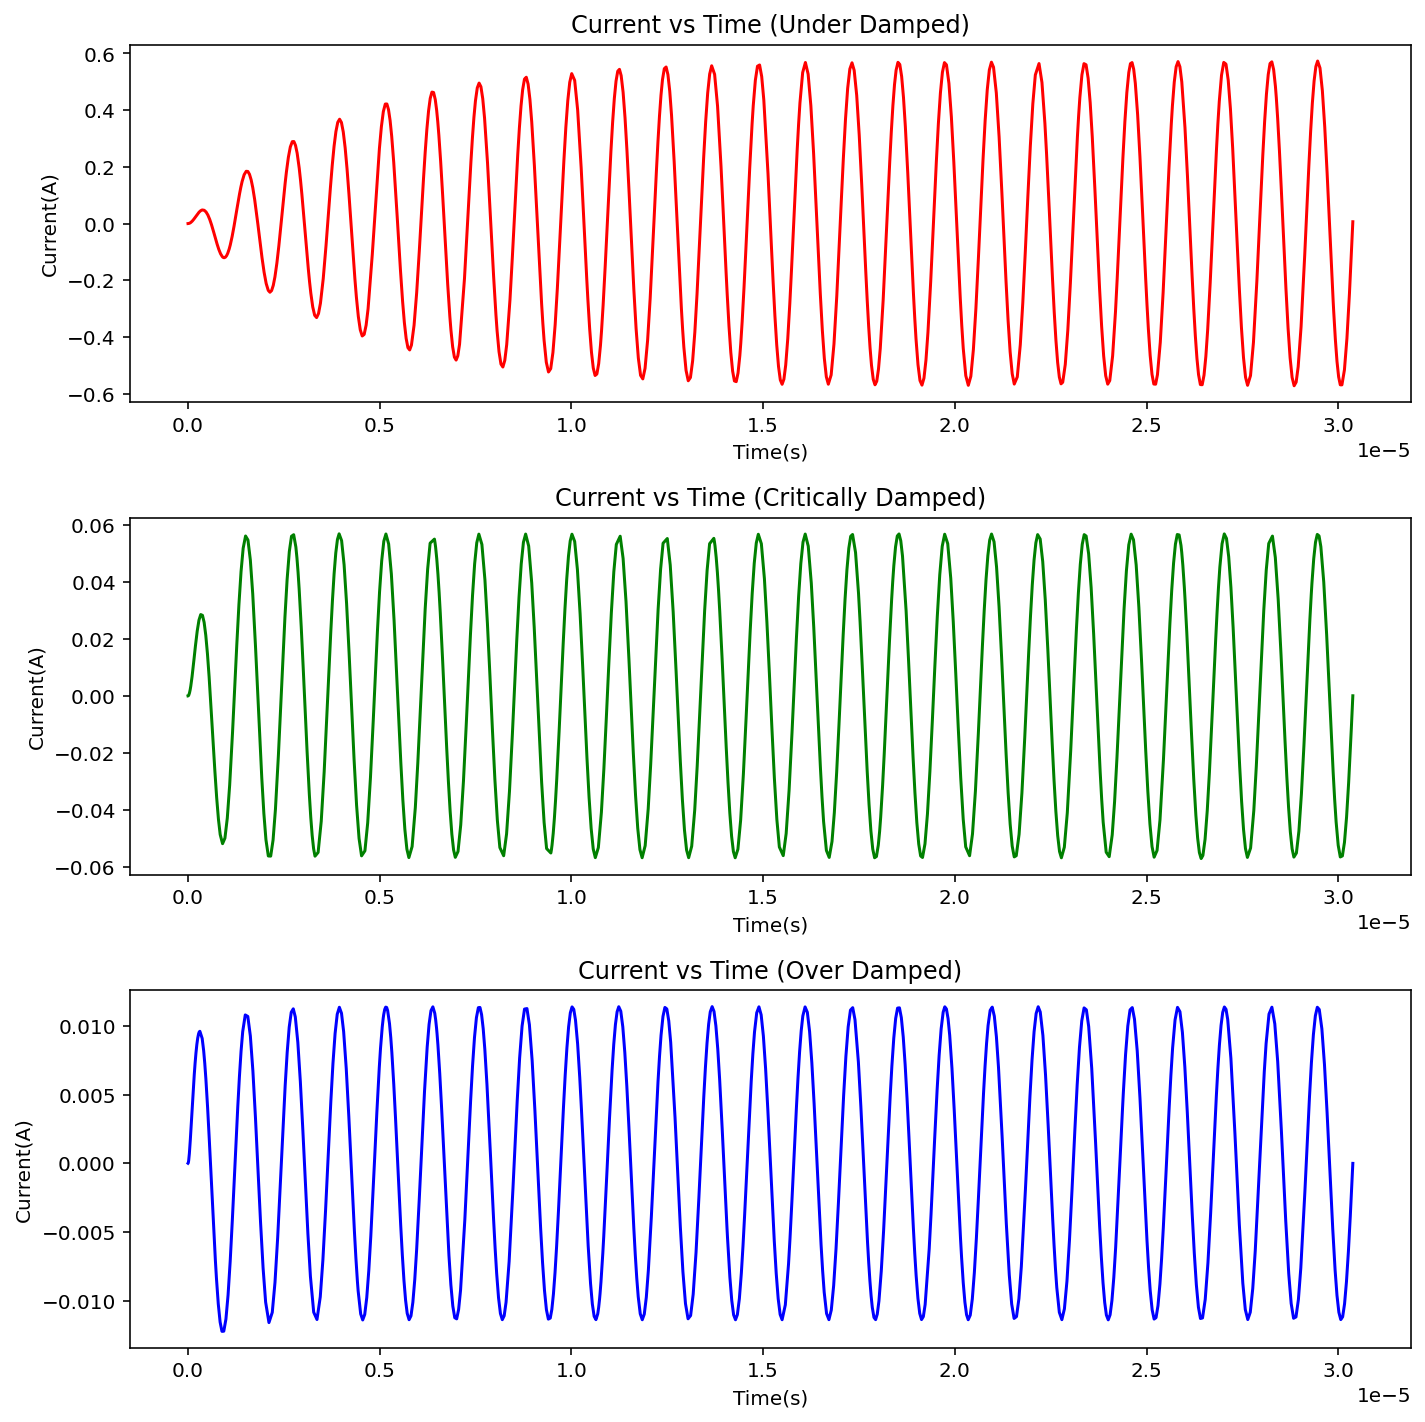

Time for unnamed cell: 0.70
Time for unnamed cell: 0.00
Time for unnamed cell: 0.00


Time for unnamed cell: 8.09


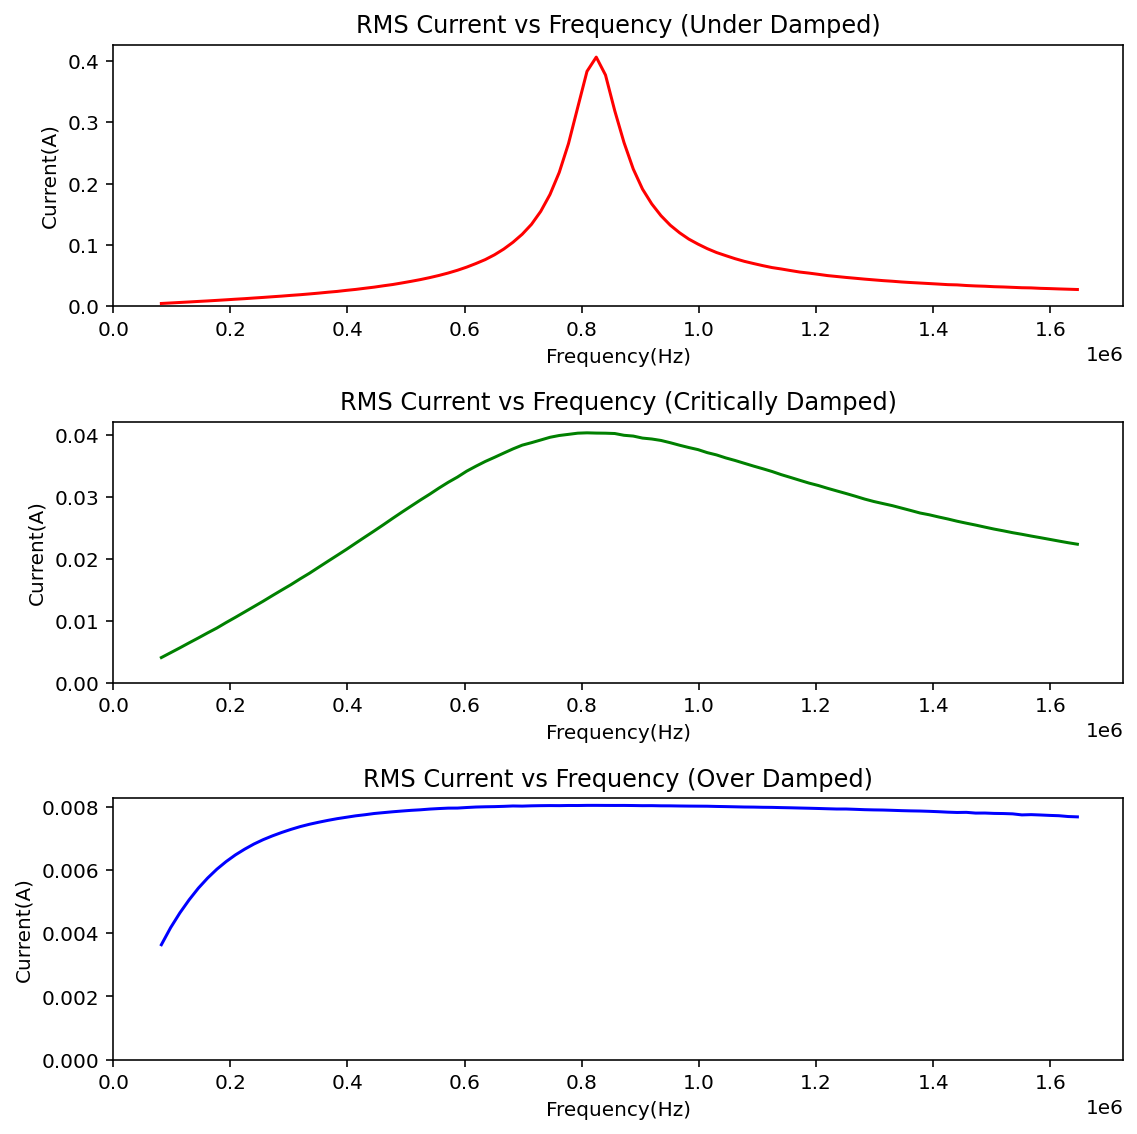

Time for unnamed cell: 0.62
Total time: 9.47


<Figure size 864x504 with 0 Axes>

In [ ]:
# Check execution time
nb_name = "project02.ipynb"
cells_to_time = []
stop_at = ['cell-extension']
%run -i time_cells2.py

In [ ]:
# 5. Code optimization/timing (grader use only)

In [ ]:
# B2. New Functionality/Language features (grader use only)